In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import scipy.misc as spm
import scipy.ndimage as spn

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
pickle_file = 'notMNIST_clean.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8913, 28, 28) (8913,)
Test set (8695, 28, 28) (8695,)


In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    #(-1, image_size, image_size, num_channels)).astype(np.float32) # Conv net
    (-1, image_size, image_size)).astype(np.float32)  # Deep net
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000, 10)
Validation set (8913, 28, 28) (8913, 10)
Test set (8695, 28, 28) (8695, 10)


0.5 -0.5


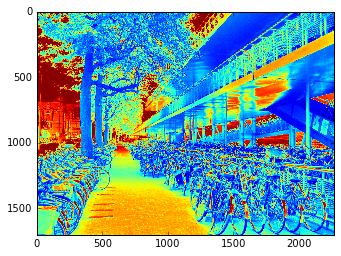

(1704, 2272)
0.5 -0.5


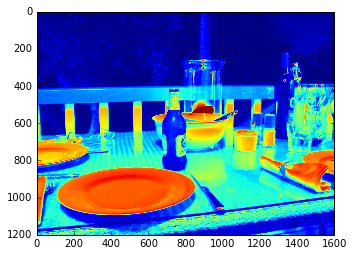

(1200, 1600)
0.5 -0.5


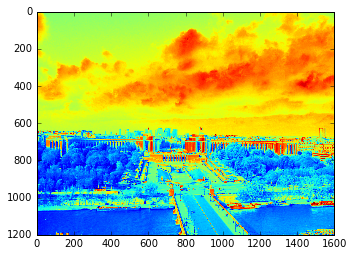

(1200, 1600)
0.5 -0.485781990521


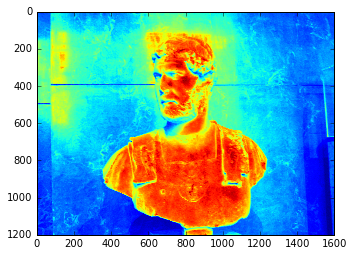

(1200, 1600)
0.5 -0.5


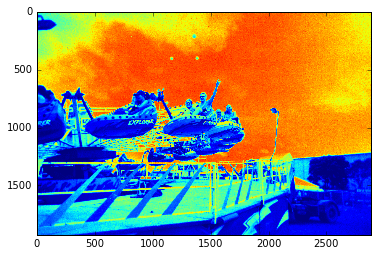

(1926, 2888)
0.5 -0.5


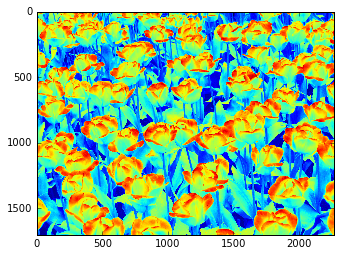

(1704, 2272)


In [5]:
# Load some backgrounds so we can get intersting pictures
def load_backgrounds(files):
    import matplotlib.image as mpimg
    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
    results = []
    for filename in files:
        img=rgb2gray(mpimg.imread(filename)).astype(np.uint8).astype(float)
        img = img / np.max(img) - 0.5
        results.append(img)
        
        print(np.max(img), np.min(img))
        plt.imshow(img)
        plt.show()
        print(img.shape)
    return results

backgrounds = load_backgrounds([
    'backgrounds/IMG_4831.jpg',
    'backgrounds/100-0048_IMG.JPG',
    'backgrounds/117-1710_IMG.JPG',
    'backgrounds/116-1607_IMG.JPG',
    'backgrounds/BRAD 3_001_P_025A.jpg',
    'backgrounds/IMG_4848.jpg'
])

In [6]:
# Create a sequence of digits from the training data
#
# returns (joined image, labels)
def create_image(train, labels, length=5):
    result_image = None
    result_labels = []    
    for a in range(length):
        # Choose random indexes for the digits
        index = np.random.randint(0, labels.shape[0])
        
        if result_image is None:
            result_image = train[index].copy()
        else:
            result_image = np.append(result_image, train[index], 1)
        
        result_labels.append(labels[index])

    return result_image, np.array(result_labels)

def show_image(data):
    print("Image shape:", data.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(data)
    plt.show()
    
def show_label(label):
    print("Label shape:", label.shape)
    result = ''
    for a in label:
        index = np.argmax(a)
        total = np.sum(a)
        if total > 0:
            result += chr(ord('A') + index)
        else:
            result += '.'
    print(result)

With training data
Image shape: (54, 144)


/home/brad/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:573: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


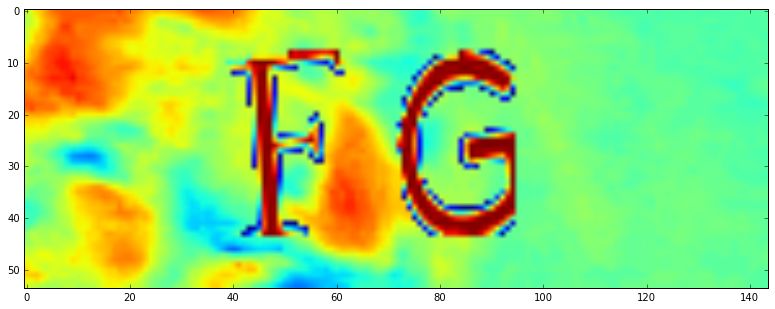

Label shape: (5, 10)
FG...
With testing data
Image shape: (54, 144)


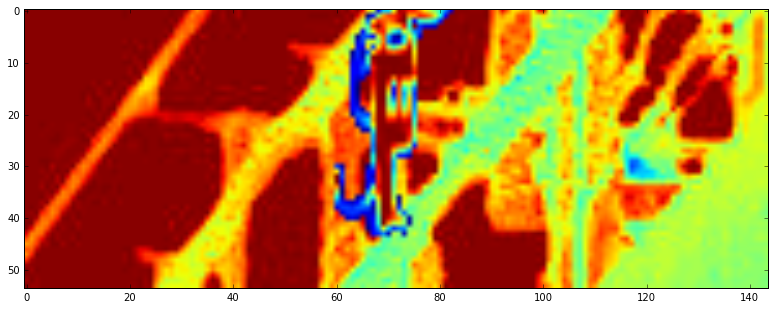

Label shape: (5, 10)
F....


In [7]:
def create_image_random(train, labels, length=5, backgrounds=None):
    new_length = np.random.randint(length) + 1
    
    size = (135, 240)
    
    result_img = np.ones((135, 240)) * -0.5
    result_labels = []
        
    img_height = train[0].shape[0]
    img_width = train[0].shape[1]
    
    x_shrink = .8 * (np.random.normal(scale=0.1) + 1)
    y_shrink = np.random.normal(scale=0.2) + 1.3
           
    # standard letter spacing is the width + 10%
    x_spacing = (img_width * 1.1) * (np.random.normal(scale=0.1) + 1) * x_shrink
            
    # y spacing randomly go up and down a little
    y_spacing = np.random.normal(scale=0.2) * 10
        
    rotate = np.random.normal() * 5
        
    y = (result_img.shape[0] / 2.) # Middle of picture
    y = y - (y_shrink * img_height / 2.)  # Average height
    y = y - ((length-1) * y_spacing / 2.) # y_spacing
    
    x = result_img.shape[1] / 2. - (new_length * x_spacing) / 2.
    
    for a in range(new_length):
        # Choose random indexes for the digits
        index = np.random.randint(0, labels.shape[0])        
                
        
        img = train[index]
        img = spm.imrotate(img, rotate)
        img = spn.interpolation.zoom(img, [y_shrink, x_shrink])
        
        # normalise the picture again
        img = img.astype(float)
        img = (img / np.max(img)) - 0.5
                
        rows, cols = img.shape
        cx = int(x)
        cy = int(y)
        result_img[cy:cy+rows, cx:cx+cols] = img
        
        del img # memory?
        
        x += x_spacing
        y += y_spacing
        
        result_labels.append(labels[index])
        
    # Lets crop the image
    y_s = int(result_img.shape[0] * .30)
    y_e = int(result_img.shape[0] * .70)
    
    x_s = int(result_img.shape[1] * .20)
    x_e = int(result_img.shape[1] * .80)
    
    result_img = result_img[y_s:y_e, x_s:x_e]
    
    if backgrounds is not None:
        pic = backgrounds[np.random.randint(len(backgrounds))]
        xs = np.random.randint(pic.shape[0] - result_img.shape[0])
        ys = np.random.randint(pic.shape[1] - result_img.shape[1])
        
        background_pic = pic[xs:xs+result_img.shape[0], ys:ys+result_img.shape[1]]
        
        rep = result_img <= -0.45
        
        output = (result_img *  np.invert(rep)) + rep * background_pic
        result_img = output
        
    while len(result_labels) < length:
        result_labels.append(np.zeros(labels[0].shape))
        
    return result_img, np.array(result_labels)

print("With training data")
image, label = create_image_random(train_dataset, train_labels, length=5, backgrounds=backgrounds)
show_image(image)
show_label(label)

print("With testing data")
image, label = create_image_random(test_dataset, test_labels, length=5, backgrounds=backgrounds)
show_image(image)
show_label(label)

0/5
Done
Image shape: (54, 144)


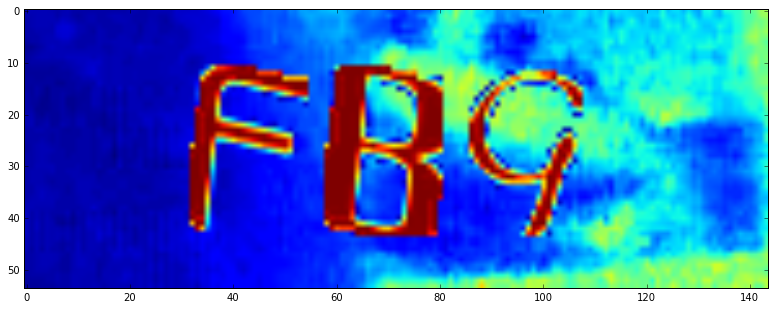

Label shape: (5, 10)
FBG..
Image shape: (54, 144)


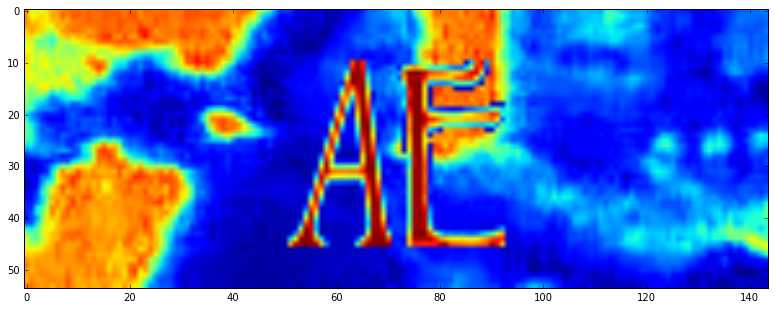

Label shape: (5, 10)
AE...
Image shape: (54, 144)


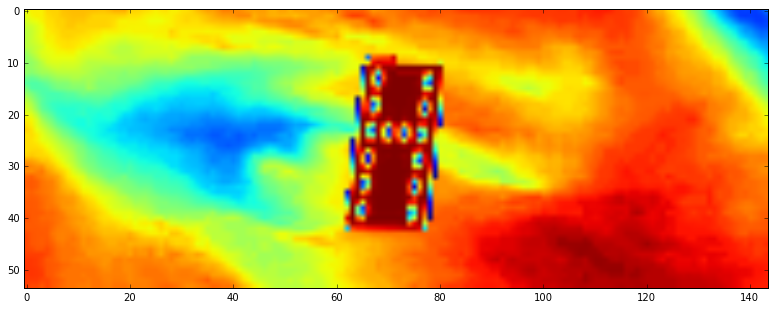

Label shape: (5, 10)
H....
Image shape: (54, 144)


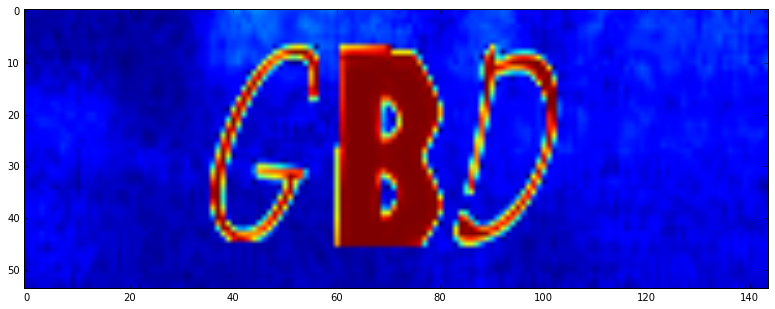

Label shape: (5, 10)
GBD..
Image shape: (54, 144)


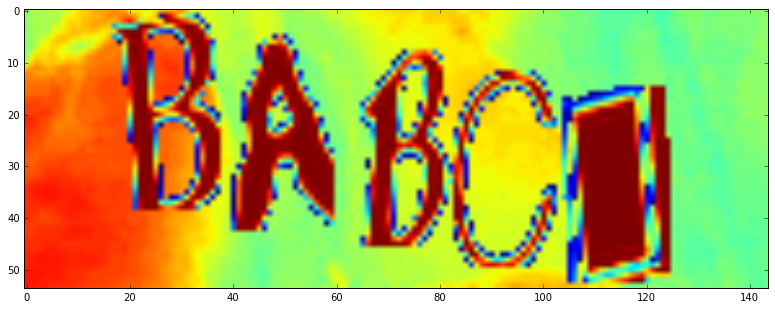

Label shape: (5, 10)
BABCI


In [10]:
# Create a batch of images and labels
def generate_batch(data, labels, length, size, **kwargs):
    result_images = []
    result_labels = []
    for i in range(size):       
        result = create_image_random(data, labels, length, **kwargs)
        result_images.append(result[0])
        result_labels.append(result[1])
        
        if i % 500 == 0:
            print("%d/%d" % (i, size))
            
    #result_images = np.array(result_images)
    #result_labels = np.array(result_labels)
    
    print("Done")
    return result_images, result_labels

images, labels = generate_batch(train_dataset, train_labels, 5, 5, backgrounds=backgrounds)
#print(images.shape)
#print(labels.shape)

for i in range(len(labels)):
    show_image(images[i])
    show_label(labels[i])
    
%xdel images
%xdel labels

In [11]:
# Create training data and save it

valid_dataset_save, valid_labels_save = generate_batch(valid_dataset, valid_labels, 5, 10000, backgrounds=backgrounds)
test_dataset_save, test_labels_save = generate_batch(test_dataset, test_labels, 5, 10000, backgrounds=backgrounds)
#train_dataset_save, train_labels_save = generate_batch(train_dataset, train_labels, 5, 20000)

print("Saving")
pickle_file = '135x240_5digits.pickle'
import os
try:
  f = open(pickle_file, 'wb')
  save = {
    #'train_dataset': train_dataset_save,
    #'train_labels': train_labels_save,
    'valid_dataset': valid_dataset_save,
    'valid_labels': valid_labels_save,
    'test_dataset': test_dataset_save,
    'test_labels': test_labels_save,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

0/10000
500/10000
1000/10000
1500/10000
2000/10000
2500/10000
3000/10000
3500/10000
4000/10000
4500/10000
5000/10000
5500/10000
6000/10000
6500/10000
7000/10000
7500/10000
8000/10000
8500/10000
9000/10000
9500/10000
Done
0/10000
500/10000
1000/10000
1500/10000
2000/10000
2500/10000
3000/10000
3500/10000
4000/10000
4500/10000
5000/10000
5500/10000
6000/10000
6500/10000
7000/10000
7500/10000
8000/10000
8500/10000
9000/10000
9500/10000
Done
Saving
Compressed pickle size: 1252739252


In [ ]:
# valid_dataset_save, valid_labels_save = generate_batch(valid_dataset, valid_labels, 5, 10000, backgrounds=backgrounds)
# test_dataset_save, test_labels_save = generate_batch(test_dataset, test_labels, 5, 10000, backgrounds=backgrounds)
train_dataset_save, train_labels_save = generate_batch(train_dataset, train_labels, 5, 20000)

print("Saving")
pickle_file = '135x240_5digits.pickle'
import os
try:
  f = open(pickle_file, 'wb')
  save = {
    #'train_dataset': train_dataset_save,
    #'train_labels': train_labels_save,
    'valid_dataset': valid_dataset_save,
    'valid_labels': valid_labels_save,
    'test_dataset': test_dataset_save,
    'test_labels': test_labels_save,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)